In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset4/train.json
/kaggle/input/dataset4/val.json


**Custom Architecture**

In [19]:
import os
import string
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW  # Using PyTorch's AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt


In [20]:
def setup_paths():
    """Setup data and output directories."""
    data_dir = "/kaggle/input/dataset4"  # Change to your dataset folder if needed
    output_dir = "/kaggle/working/"
    os.makedirs(output_dir, exist_ok=True)
    return data_dir, output_dir

def load_model_and_tokenizer():
    """Load the BERT tokenizer and model."""
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")
    return tokenizer, bert_model


In [21]:
def remove_punctuation(sentence):
    translator = str.maketrans('', '', string.punctuation)
    return sentence.translate(translator)

def tokenize_sentence(sentence):
    """Tokenize sentence by removing punctuation and splitting on whitespace."""
    return remove_punctuation(sentence).split()

def preprocess_data(input_file, output_file):
    """
    Read the raw JSON file, process each entry by tokenizing the sentence and aspect terms,
    compute the aspect index, and save the formatted data.
    """
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    formatted_data = []
    
    for entry in data:
        sentence = entry['sentence'].lower()
        aspect_terms = entry['aspect_terms']
        tokens = tokenize_sentence(sentence)
        
        for aspect in aspect_terms:
            a_from = int(aspect['from'])
            a_to = int(aspect['to'])
            # Tokenize the aspect term (wrapped in a list to mimic your original structure)
            aspect_term = tokenize_sentence(aspect['term'].lower())
            polarity = aspect['polarity']
            
            # Compute token index corresponding to the aspect start (counting spaces)
            index = 0
            for i in range(a_from):
                if sentence[i] == " ":
                    index += 1
                    
            formatted_entry = {
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': [aspect_term],
                'index': index
            }
            formatted_data.append(formatted_entry)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(formatted_data, f, indent=4)


In [22]:
def run_preprocessing(data_dir, output_dir):
    """Run preprocessing for both training and validation files."""
    preprocess_data(os.path.join(data_dir, "train.json"), os.path.join(output_dir, "train_task2.json"))
    preprocess_data(os.path.join(data_dir, "val.json"), os.path.join(output_dir, "val_task2.json"))


In [23]:
class AspectSentimentDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len=50, aspect_max_len=5):
        with open(file_path, "r") as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.aspect_max_len = aspect_max_len
        self.polarity_to_idx = {"negative": 0, "neutral": 1, "positive": 2, "conflict": 3}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        # Reconstruct the sentence and aspect term strings from tokens
        sentence = " ".join(example["tokens"])
        # Note: aspect_term is stored as a list of tokens lists; here we simply join the first one
        aspect_term = " ".join(example["aspect_term"][0])
        
        sentence_encoded = self.tokenizer.encode_plus(
            sentence, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )
        aspect_encoded = self.tokenizer.encode_plus(
            aspect_term, max_length=self.aspect_max_len, padding="max_length", truncation=True, return_tensors="pt"
        )
        
        polarity = example["polarity"]
        polarity_idx = torch.tensor(self.polarity_to_idx[polarity], dtype=torch.long)
        
        return (sentence_encoded["input_ids"].squeeze(0), 
                sentence_encoded["attention_mask"].squeeze(0), 
                aspect_encoded["input_ids"].squeeze(0), 
                aspect_encoded["attention_mask"].squeeze(0), 
                polarity_idx)

In [24]:
def create_dataloader(file_path, tokenizer, batch_size=32, max_len=50, aspect_max_len=5):
    dataset = AspectSentimentDataset(file_path, tokenizer, max_len, aspect_max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [25]:
class AttentionBasedLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes, num_layers=2, bidirectional=False, dropout=0.4):
        super(AttentionBasedLSTM, self).__init__()
        self.bert = bert_model
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # LSTM encoder: input size is the BERT hidden size (768)
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        # Attention mechanism
        self.W_h = nn.Linear(hidden_dim * self.num_directions, hidden_dim, bias=False)
        self.W_v = nn.Linear(768, hidden_dim, bias=False)  # For aspect embeddings
        self.att_vector = nn.Parameter(torch.Tensor(hidden_dim + hidden_dim))
        nn.init.xavier_uniform_(self.att_vector.unsqueeze(0))
        
        # Projection layers
        self.W_p = nn.Linear(hidden_dim * self.num_directions, hidden_dim)
        self.W_x = nn.Linear(hidden_dim * self.num_directions, hidden_dim)
        
        # Classification layer
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, text_ids, text_mask, aspect_ids, aspect_mask):
        # Get BERT embeddings for the sentence and aspect term
        text_embedded = self.bert(text_ids, attention_mask=text_mask).last_hidden_state
        aspect_embedded = self.bert(aspect_ids, attention_mask=aspect_mask).last_hidden_state.mean(dim=1)  # Average aspect embeddings
        
        # LSTM Encoding
        output, (h_n, c_n) = self.lstm(text_embedded)
        if self.bidirectional:
            h_N = torch.cat((h_n[-2], h_n[-1]), dim=-1)
        else:
            h_N = h_n[-1]

        # Attention Mechanism
        transformed_H = self.W_h(output)
        transformed_va = self.W_v(aspect_embedded).unsqueeze(1).repeat(1, output.size(1), 1)
        M = torch.tanh(torch.cat([transformed_H, transformed_va], dim=-1))
        att_scores = torch.matmul(M, self.att_vector)
        alpha = F.softmax(att_scores, dim=1)
        r = torch.sum(alpha.unsqueeze(-1) * output, dim=1)

        # Combine representations and classify
        h_star = torch.tanh(self.W_p(r) + self.W_x(h_N))
        logits = self.classifier(h_star)
        return logits

In [26]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=100):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0.0, 0, 0
        for batch in train_dataloader:
            sentences, sentence_masks, aspects, aspect_masks, labels = batch
            sentences = sentences.to(device)
            sentence_masks = sentence_masks.to(device)
            aspects = aspects.to(device)
            aspect_masks = aspect_masks.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            logits = model(sentences, sentence_masks, aspects, aspect_masks)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * sentences.size(0)
            _, preds = torch.max(logits, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += sentences.size(0)
        
        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        total_loss, total_correct, total_samples = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                sentences, sentence_masks, aspects, aspect_masks, labels = batch
                sentences = sentences.to(device)
                sentence_masks = sentence_masks.to(device)
                aspects = aspects.to(device)
                aspect_masks = aspect_masks.to(device)
                labels = labels.to(device)
                
                logits = model(sentences, sentence_masks, aspects, aspect_masks)
                loss = criterion(logits, labels)
                
                total_loss += loss.item() * sentences.size(0)
                _, preds = torch.max(logits, 1)
                total_correct += (preds == labels).sum().item()
                total_samples += sentences.size(0)
        
        val_loss = total_loss / total_samples
        val_acc = total_correct / total_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [27]:
def plot_training(train_losses, train_accuracies, val_losses, val_accuracies, output_dir, num_epochs):
    epochs_range = range(1, num_epochs+1)
    plt.figure(figsize=(12, 5))
    
    # Loss vs. Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid(True)
    
    # Accuracy vs. Epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, 'g-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_plots.png"))
    plt.show()

Epoch 1/20 | Train Loss: 1.0202, Train Acc: 0.6170 | Val Loss: 0.9447, Val Acc: 0.6523
Epoch 2/20 | Train Loss: 0.7295, Train Acc: 0.7339 | Val Loss: 0.8284, Val Acc: 0.6954
Epoch 3/20 | Train Loss: 0.6008, Train Acc: 0.7896 | Val Loss: 0.8356, Val Acc: 0.7116
Epoch 4/20 | Train Loss: 0.5228, Train Acc: 0.8207 | Val Loss: 0.7818, Val Acc: 0.7116
Epoch 5/20 | Train Loss: 0.4665, Train Acc: 0.8362 | Val Loss: 0.8217, Val Acc: 0.6927
Epoch 6/20 | Train Loss: 0.4181, Train Acc: 0.8436 | Val Loss: 0.8033, Val Acc: 0.7089
Epoch 7/20 | Train Loss: 0.3848, Train Acc: 0.8551 | Val Loss: 0.7361, Val Acc: 0.7089
Epoch 8/20 | Train Loss: 0.3509, Train Acc: 0.8612 | Val Loss: 0.7380, Val Acc: 0.6739
Epoch 9/20 | Train Loss: 0.3241, Train Acc: 0.8598 | Val Loss: 0.7552, Val Acc: 0.7008
Epoch 10/20 | Train Loss: 0.3064, Train Acc: 0.8707 | Val Loss: 0.7818, Val Acc: 0.7197
Epoch 11/20 | Train Loss: 0.2866, Train Acc: 0.8656 | Val Loss: 0.8910, Val Acc: 0.7035
Epoch 12/20 | Train Loss: 0.2850, Train A

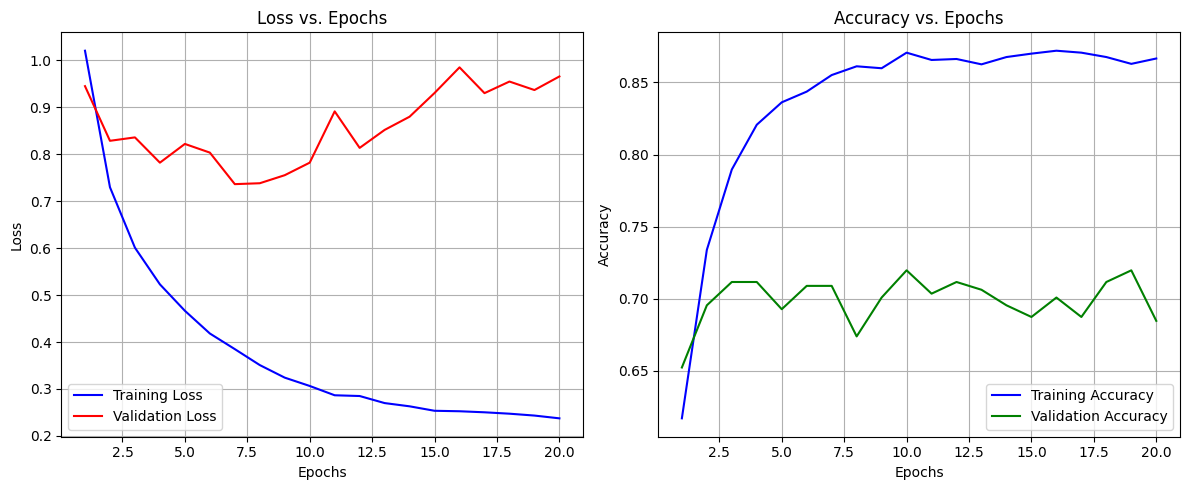

In [29]:
data_dir, output_dir = setup_paths()
tokenizer, bert_model = load_model_and_tokenizer()

# Preprocess data files (train and validation)
run_preprocessing(data_dir, output_dir)

# Create DataLoaders for training and validation
train_file = os.path.join(output_dir, "train_task2.json")
val_file = os.path.join(output_dir, "val_task2.json")
train_dataloader = create_dataloader(train_file, tokenizer, batch_size=32)
val_dataloader = create_dataloader(val_file, tokenizer, batch_size=32)

# Initialize model, criterion, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionBasedLSTM(bert_model, hidden_dim=128, num_classes=4, bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

# Train the model
num_epochs = 20
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs
)

# Plot the training history
plot_training(train_losses, train_accuracies, val_losses, val_accuracies, output_dir, num_epochs)

In [31]:
def save_model(model, save_path):
    """
    Save the model's state dictionary to the given file path.
    """
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


def load_model_and_compute_accuracy(model_class, model_path, test_filename, device, batch_size=64):
    """
    Load a trained model from 'model_path' and compute its accuracy on the test dataset.

    Parameters:
        model_class: The class of the model (e.g., AttentionBasedLSTM)
        model_path: Path to the saved model file.
        test_filename: Filename (in output_dir) of the test data (formatted like your train/val data).
        device: The device (cpu or cuda) to map the model and data.
        batch_size: Batch size for evaluation (default: 64).

    Returns:
        The test accuracy as a float.
    """
    # Instantiate the model with the same architecture parameters as during training.
    loaded_model = model_class(bert_model, hidden_dim=128, num_classes=4, bidirectional=True)
    loaded_model.load_state_dict(torch.load(model_path, map_location=device))
    loaded_model.to(device)
    loaded_model.eval()

    preprocess_data(os.path.join(data_dir, test_filename), os.path.join(output_dir, "test_task2.json"))
    
    # Load test dataset (assumes test_filename is in output_dir and formatted appropriately)
    test_dataloader = create_dataloader("test_task2.json", tokenizer, batch_size=32, max_len=50, aspect_max_len=5)
    
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_dataloader:
            sentences, sentence_masks, aspects, aspect_masks, labels = batch
            sentences = sentences.to(device)
            sentence_masks = sentence_masks.to(device)
            aspects = aspects.to(device)
            aspect_masks = aspect_masks.to(device)
            labels = labels.to(device)
            
            logits = loaded_model(sentences, sentence_masks, aspects, aspect_masks)
            _, preds = torch.max(logits, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy


In [32]:
save_model(model, os.path.join(output_dir, "attention_based_trained_model.pt"))


Model saved to /kaggle/working/attention_based_trained_model.pt


In [34]:
# test_accuracy = load_model_and_compute_accuracy(AttentionBasedLSTM, 
#                                                   os.path.join(output_dir, "attention_based_trained_model.pt"), 
#                                                   "test.json", 
#                                                   device)


<ipython-input-31-82844770eea4>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy: 0.6846


**Finetuning for BART,BERT,Roberta**

In [81]:
import os
import json
import string
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import (
    AdamW,
    get_scheduler,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    BartTokenizer,
    BartForSequenceClassification
)

In [82]:
def remove_punctuation(text):
    """Remove punctuation from text."""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def tokenize_sentence(sentence):
    """Tokenize a sentence by removing punctuation and splitting into words."""
    return remove_punctuation(sentence).split()


In [83]:

# --------------------------
# Data Preprocessing Functions
# --------------------------
def preprocess_data(input_filename, output_filename, raw_dir, processed_dir):
    """
    Read raw data from a JSON file, tokenize the sentence and aspect terms,
    and write the processed data to a new JSON file.
    """
    in_path = os.path.join(raw_dir, input_filename)
    out_path = os.path.join(processed_dir, output_filename)
    with open(in_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    processed = []
    for entry in data:
        # Lowercase the sentence and tokenize it.
        sentence = entry['sentence'].lower()
        tokens = tokenize_sentence(sentence)
        # Process each aspect term.
        for aspect in entry['aspect_terms']:
            a_from = int(aspect['from'])
            aspect_tokens = tokenize_sentence(aspect['term'].lower())
            polarity = aspect['polarity']
            # Calculate word index by counting spaces up to a_from.
            word_index = sum(1 for i in range(a_from) if sentence[i] == " ")
            processed.append({
                'tokens': tokens,
                'polarity': polarity,
                'aspect_term': aspect_tokens,
                'index': word_index
            })
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump(processed, f, indent=4)
    print(f"Preprocessed data saved to {out_path}")


In [84]:
def load_processed_data(filename, processed_dir):
    """Load the preprocessed JSON data from a file."""
    path = os.path.join(processed_dir, filename)
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


In [85]:

def convert_to_dataset(data):
    """
    Convert the processed data into a Hugging Face Dataset.
    Reconstruct sentences and aspect terms from token lists.
    """
    sentences, aspects, polarities = [], [], []
    for item in data:
        sentences.append(" ".join(item["tokens"]))
        aspects.append(" ".join(item["aspect_term"]))
        polarities.append(item["polarity"])
    return Dataset.from_dict({
        "sentence": sentences,
        "aspect_term": aspects,
        "polarity": polarities
    })


In [86]:

def add_model_inputs(examples, label_mapping):
    """
    Create model input strings by combining sentence and aspect term.
    Convert polarity labels to integers.
    """
    inputs = [f"{s} [SEP] {a}" for s, a in zip(examples["sentence"], examples["aspect_term"])]
    labels = [label_mapping[label] for label in examples["polarity"]]
    return {"inputs": inputs, "labels": labels}

def tokenize_inputs(examples, tokenizer):
    """Tokenize the input strings using the given tokenizer."""
    return tokenizer(examples["inputs"], padding="max_length", truncation=True, max_length=128)


In [87]:

# --------------------------
# Model and Tokenizer Loader
# --------------------------
def get_tokenizer_and_model(model_type, num_labels):
    """
    Return the tokenizer and model based on the specified model type.
    Supported types: "bert", "roberta", "bart".
    """
    model_type = model_type.lower()
    if model_type == "bert":
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
    elif model_type == "roberta":
        tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)
    elif model_type == "bart":
        tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=num_labels)
    else:
        raise ValueError("Unsupported model type.")
    return tokenizer, model


In [88]:

# --------------------------
# DataLoader Creation
# --------------------------
def create_dataloaders(train_dataset, val_dataset, tokenizer, batch_size):
    """
    Tokenize the datasets and create DataLoader objects for training and validation.
    """
    tokenized_train = train_dataset.map(lambda x: tokenize_inputs(x, tokenizer), batched=True)
    tokenized_val = val_dataset.map(lambda x: tokenize_inputs(x, tokenizer), batched=True)
    tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    train_loader = DataLoader(tokenized_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(tokenized_val, batch_size=batch_size)
    return train_loader, val_loader


In [89]:

# --------------------------
# Training and Evaluation Loop
# --------------------------
def train_and_evaluate(model, train_loader, val_loader, num_epochs, device):
    """
    Train the model and evaluate on the validation set.
    Return lists of losses and accuracies.
    """
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = num_epochs * len(train_loader)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct, total = 0, 0
        for batch in train_loader:
            # Move batch data to device.
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            outputs = model(**batch)
            loss = outputs.loss
            epoch_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        train_losses.append(epoch_loss / len(train_loader))
        train_accs.append(correct / total)
        
        model.eval()
        eval_loss, correct_eval, total_eval = 0, 0, 0
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            with torch.no_grad():
                outputs = model(**batch)
            eval_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            correct_eval += (preds == batch["labels"]).sum().item()
            total_eval += batch["labels"].size(0)
        val_losses.append(eval_loss / len(val_loader))
        val_accs.append(correct_eval / total_eval)
        
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accs[-1]:.4f} | "
              f"Val Loss={val_losses[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")
    return train_losses, train_accs, val_losses, val_accs


In [90]:

# --------------------------
# Plotting Function
# --------------------------
def plot_metrics(train_losses, val_losses, train_accs, val_accs, out_dir, model_type):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'g-', label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs. Epoch ({model_type.capitalize()})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, f"{model_type}_loss.png"))
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accs, 'b-', label='Train Acc')
    plt.plot(epochs, val_accs, 'g-', label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy vs. Epoch ({model_type.capitalize()})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, f"{model_type}_accuracy.png"))
    plt.show()


In [94]:

# --------------------------
# Main Function
# --------------------------
def run_the_model(model_type="bart", batch_size=16, num_epochs=15):
    # Preprocess raw data
    preprocess_data("train.json", "train_task2.json", data_dir, output_dir)
    preprocess_data("val.json", "val_task2.json", data_dir, output_dir)
    
    # Load processed data and convert to dataset
    train_data = load_processed_data("train_task2.json",output_dir)
    val_data = load_processed_data("val_task2.json",output_dir)
    train_dataset = convert_to_dataset(train_data)
    val_dataset = convert_to_dataset(val_data)
    
    print(f"Train dataset: {len(train_dataset)} entries")
    print(f"Val dataset: {len(val_dataset)} entries")
    print("Sample:", train_dataset[0])
    
    # Map polarity strings to labels and add model inputs.
    label_mapping = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}
    train_dataset = train_dataset.map(lambda x: add_model_inputs(x, label_mapping), batched=True)
    val_dataset = val_dataset.map(lambda x: add_model_inputs(x, label_mapping), batched=True)
    
    # Get the tokenizer and model based on the selected type.
    tokenizer, model = get_tokenizer_and_model(model_type, num_labels=len(label_mapping))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Create dataloaders
    train_loader, val_loader = create_dataloaders(train_dataset, val_dataset, tokenizer, batch_size)
    
    # Train and evaluate the model.
    train_losses, train_accs, val_losses, val_accs = train_and_evaluate(model, train_loader, val_loader, num_epochs, device)
    
    # Plot training metrics.
    plot_metrics(train_losses, val_losses, train_accs, val_accs, output_dir, model_type)
    return model

Preprocessed data saved to /kaggle/working/train_task2.json
Preprocessed data saved to /kaggle/working/val_task2.json
Train dataset: 2961 entries
Val dataset: 371 entries
Sample: {'sentence': 'but the staff was so horrible to us', 'aspect_term': 'staff', 'polarity': 'negative'}


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Epoch 1: Train Loss=0.8380, Train Acc=0.6785 | Val Loss=0.7664, Val Acc=0.7143
Epoch 2: Train Loss=0.6267, Train Acc=0.7693 | Val Loss=0.6830, Val Acc=0.7224
Epoch 3: Train Loss=0.5047, Train Acc=0.8122 | Val Loss=0.6810, Val Acc=0.7655
Epoch 4: Train Loss=0.4056, Train Acc=0.8490 | Val Loss=0.6782, Val Acc=0.7682
Epoch 5: Train Loss=0.3361, Train Acc=0.8784 | Val Loss=0.7638, Val Acc=0.7655
Epoch 6: Train Loss=0.2888, Train Acc=0.8963 | Val Loss=0.6968, Val Acc=0.7439
Epoch 7: Train Loss=0.2339, Train Acc=0.9135 | Val Loss=0.7233, Val Acc=0.7736
Epoch 8: Train Loss=0.2147, Train Acc=0.9230 | Val Loss=0.7683, Val Acc=0.7736
Epoch 9: Train Loss=0.1899, Train Acc=0.9325 | Val Loss=0.7458, Val Acc=0.7628
Epoch 10: Train Loss=0.1785, Train Acc=0.9399 | Val Loss=0.7522, Val Acc=0.7655


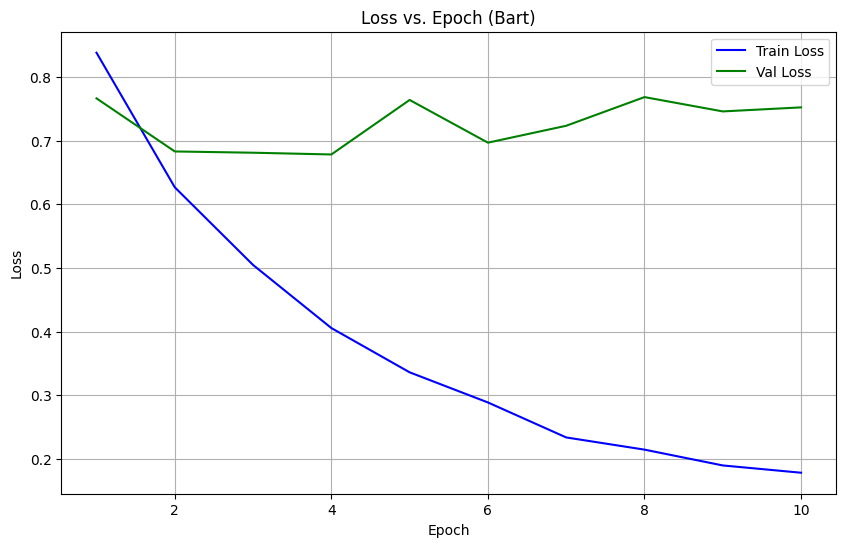

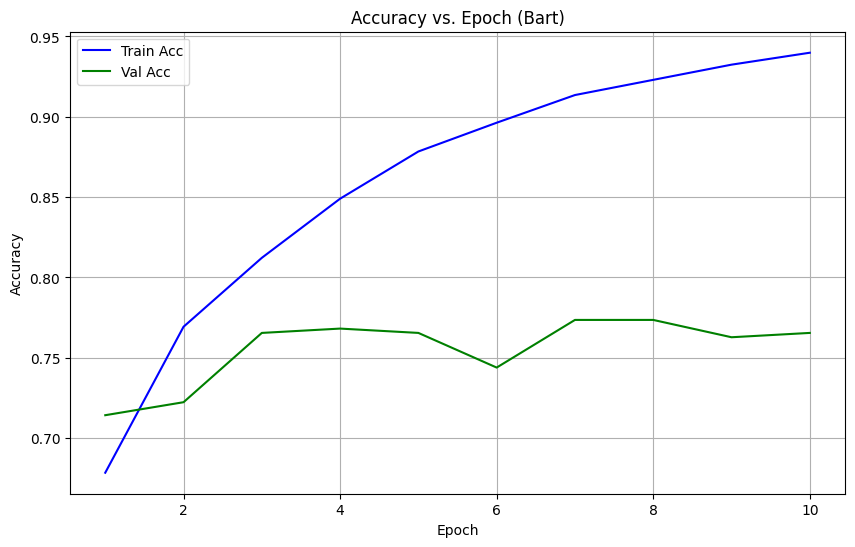

Preprocessed data saved to /kaggle/working/train_task2.json
Preprocessed data saved to /kaggle/working/val_task2.json
Train dataset: 2961 entries
Val dataset: 371 entries
Sample: {'sentence': 'but the staff was so horrible to us', 'aspect_term': 'staff', 'polarity': 'negative'}


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Epoch 1: Train Loss=0.9322, Train Acc=0.6268 | Val Loss=0.8586, Val Acc=0.6253
Epoch 2: Train Loss=0.6534, Train Acc=0.7528 | Val Loss=0.7658, Val Acc=0.7008
Epoch 3: Train Loss=0.4946, Train Acc=0.8129 | Val Loss=0.7463, Val Acc=0.7224
Epoch 4: Train Loss=0.3520, Train Acc=0.8696 | Val Loss=0.8238, Val Acc=0.7439
Epoch 5: Train Loss=0.2375, Train Acc=0.9193 | Val Loss=0.8159, Val Acc=0.7466
Epoch 6: Train Loss=0.1714, Train Acc=0.9419 | Val Loss=0.9587, Val Acc=0.7466
Epoch 7: Train Loss=0.1308, Train Acc=0.9551 | Val Loss=1.0216, Val Acc=0.7547
Epoch 8: Train Loss=0.0933, Train Acc=0.9710 | Val Loss=0.9777, Val Acc=0.7493
Epoch 9: Train Loss=0.0722, Train Acc=0.9787 | Val Loss=1.0209, Val Acc=0.7412
Epoch 10: Train Loss=0.0653, Train Acc=0.9818 | Val Loss=1.0373, Val Acc=0.7574


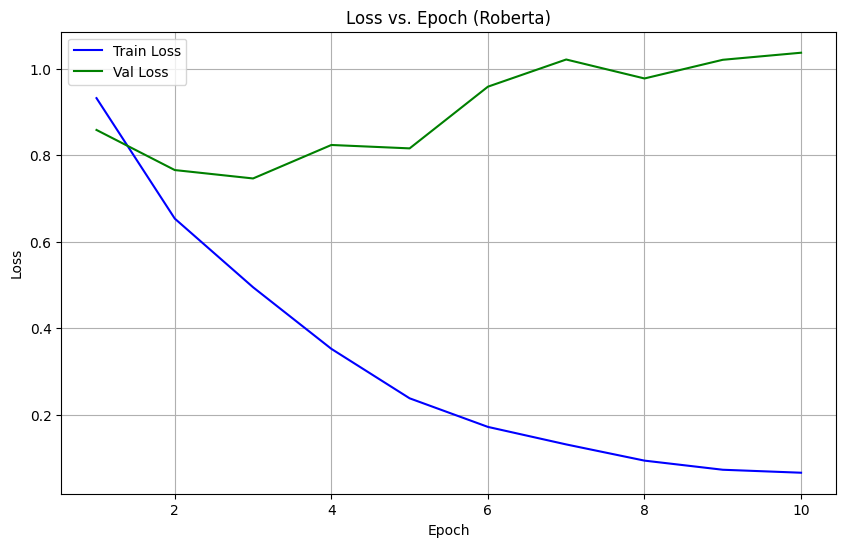

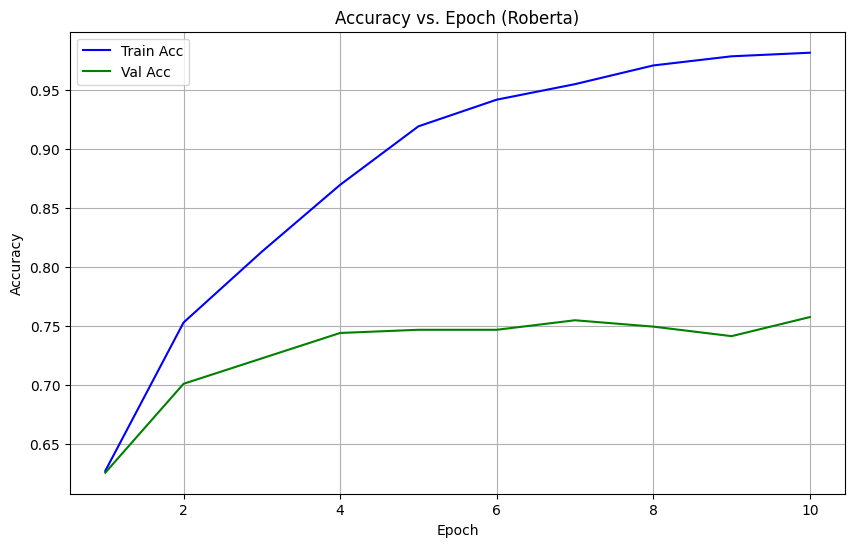

Preprocessed data saved to /kaggle/working/train_task2.json
Preprocessed data saved to /kaggle/working/val_task2.json
Train dataset: 2961 entries
Val dataset: 371 entries
Sample: {'sentence': 'but the staff was so horrible to us', 'aspect_term': 'staff', 'polarity': 'negative'}


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2961 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Epoch 1: Train Loss=0.9117, Train Acc=0.6491 | Val Loss=0.8546, Val Acc=0.6604
Epoch 2: Train Loss=0.6354, Train Acc=0.7616 | Val Loss=0.7499, Val Acc=0.6954
Epoch 3: Train Loss=0.4813, Train Acc=0.8224 | Val Loss=0.7174, Val Acc=0.7170
Epoch 4: Train Loss=0.3518, Train Acc=0.8794 | Val Loss=0.7544, Val Acc=0.7466
Epoch 5: Train Loss=0.2365, Train Acc=0.9179 | Val Loss=0.7933, Val Acc=0.7197
Epoch 6: Train Loss=0.1642, Train Acc=0.9537 | Val Loss=0.8269, Val Acc=0.7385
Epoch 7: Train Loss=0.1206, Train Acc=0.9645 | Val Loss=0.9111, Val Acc=0.7251
Epoch 8: Train Loss=0.0955, Train Acc=0.9713 | Val Loss=0.9403, Val Acc=0.7251
Epoch 9: Train Loss=0.0788, Train Acc=0.9767 | Val Loss=0.9645, Val Acc=0.7385
Epoch 10: Train Loss=0.0636, Train Acc=0.9841 | Val Loss=0.9521, Val Acc=0.7251


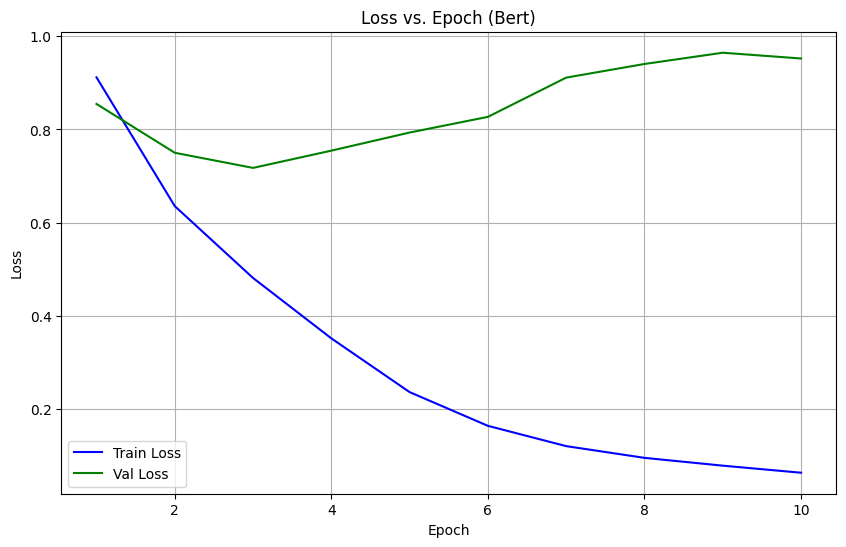

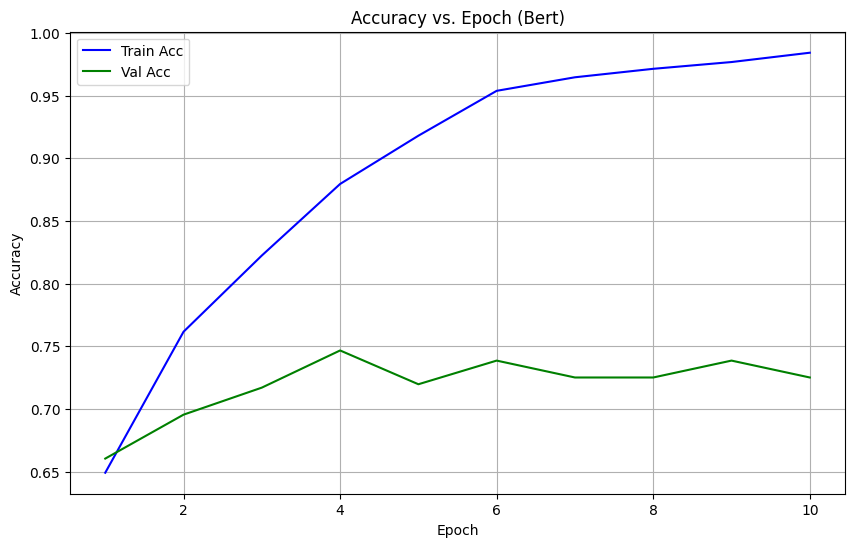

In [95]:
model_bart=run_the_model(model_type="bart", batch_size=32, num_epochs=10)
model_roberta=run_the_model(model_type="roberta", batch_size=32, num_epochs=10)
model_bert=run_the_model(model_type="bert", batch_size=32, num_epochs=10)


In [96]:
def load_and_evaluate_model(model_type, saved_model_path, test_filename, processed_dir, batch_size=32):
    # Define label mapping (ensure it matches your training configuration).
    label_mapping = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}
    
    # Load the tokenizer and model for the specified model type.
    tokenizer, model = get_tokenizer_and_model(model_type, num_labels=len(label_mapping))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Load the trained model state.
    model.load_state_dict(torch.load(saved_model_path, map_location=device))
    
    # Load and process test data.
    test_data = load_processed_data(test_filename, processed_dir)
    test_dataset = convert_to_dataset(test_data)
    # Map polarity strings to labels and create combined inputs.
    test_dataset = test_dataset.map(lambda x: add_model_inputs(x, label_mapping), batched=True)
    # Tokenize the inputs.
    tokenized_test = test_dataset.map(lambda x: tokenize_inputs(x, tokenizer), batched=True)
    tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    
    # Create DataLoader for test set.
    test_loader = DataLoader(tokenized_test, batch_size=batch_size)
    
    # Evaluate the model.
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch in test_loader:
            # Move batch to device.
            batch = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask", "labels"]}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item() * batch["labels"].size(0)
            preds = torch.argmax(outputs.logits, dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    
    return avg_loss, accuracy

def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


In [97]:
save_model(model_bart, os.path.join(output_dir, "bart_trained_model.pt"))
save_model(model_roberta, os.path.join(output_dir, "roberta_trained_model.pt"))
save_model(model_bert, os.path.join(output_dir, "bert_trained_model.pt"))


Model saved to /kaggle/working/bart_trained_model.pt
Model saved to /kaggle/working/roberta_trained_model.pt
Model saved to /kaggle/working/bert_trained_model.pt


In [100]:
# preprocess_data("test.json", "test_task2.json", data_dir, output_dir)

# avg_loss, accuracy = load_and_evaluate_model(
#     model_type="bart",
#     saved_model_path=os.path.join(output_dir, "bart_trained_model.pt"),
#     test_filename="test_task2.json",
#     processed_dir="/kaggle/working/",
#     batch_size=32
# )
# avg_loss, accuracy = load_and_evaluate_model(
#     model_type="roberta",
#     saved_model_path=os.path.join(output_dir, "roberta_trained_model.pt"),
#     test_filename="test_task2.json",
#     processed_dir="/kaggle/working/",
#     batch_size=32
# )
# avg_loss, accuracy = load_and_evaluate_model(
#     model_type="bert",
#     saved_model_path=os.path.join(output_dir, "bert_trained_model.pt"),
#     test_filename="test_task2.json",
#     processed_dir="/kaggle/working/",
#     batch_size=32
# )


Preprocessed data saved to /kaggle/working/test_task2.json


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-96-ca706915156b>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Test Loss: 0.7553, Test Accuracy: 0.7655


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Test Loss: 1.0438, Test Accuracy: 0.7574


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

Test Loss: 0.9533, Test Accuracy: 0.7251
